# **Lab 8: Matrix Factorization**

---
NOTE: This is a lab project accompanying the following book [MLF] and it should be used together with the book.

[MLF] *H. Jiang*, "[Machine Learning Fundamentals: A Concise Introduction](http://wiki.eecs.yorku.ca/user/hj/research:mlfbook)", Cambridge University Press, 2021.  ([bibtex](http://www.cse.yorku.ca/~huijiang/mlf-jiang.bib))

---

The aim of this lab is to explore the application of machine learning techniques to the large-scale matrix factorization problem, which has numerous practical uses, such as collaborative filtering for recommendations and latent semantic analysis (LSA) in natural language processing. Specifically, we will employ LSA on the well-known *enwiki8* dataset as a case study to demonstrate how machine learning methods can be used to factorize large-scale sparse matrices derived from extensive text corpora. This will include efficient computation of the loss function, optimization of the loss function using various methods such as the alternating algorithm and stochastic gradient descent (SGD), and a discussion of their practical advantages and disadvantages.

*Prerequisites*: basic understanding on JAX, including `jax.numpy` and `jax.grad`.

### **Example 8.1:**

Use `scikit-learn` to construct the word-document matrix (as in Example 7.3.2 on page 142) for the top 10000 most frequent words in the  *enwiki8* dataset, where each paragraph in a line is treated as a document. Next, use `numpy` to implement the Alternating algorithm (Algorithm 7.6 on page 145) to factorize the word-document matrix to derive word vectors with dimension $k=20$. Furthermore, use the `t_SNE` method to visualize the top 500 most frequent words to inspect their semantic relationships. At last, compare the execution times of the alternating algorithm for various word vector dimensions $k=10,20,30$.


In [1]:
# download enwiki8 dataset from Google drive

#!gdown https://drive.google.com/file/d/1lNpX1UHSKg-o4NQOcGZOr2x4ew0p7S1k 2> /dev/null

# OR download enwiki8.txt from YorkU server

!wget -q http://www.cse.yorku.ca/~huijiang/enwiki8.txt.zip

!unzip -q -o enwiki8.txt.zip

In [2]:
# load enwiki8.txt as a python list

with open('enwiki8.txt', 'r') as f:
  lines = f.readlines()
  text = []

  for line in lines:
    text.append(line)

print(len(text))

489860


In [3]:
# create word-document matrix using scikit-learn

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=10000)   # vocabulary size = 10000
X = vectorizer.fit_transform(text).transpose()     # Note that X is a sparse matrix (scipy.sparse.csr_matrix)
print(X.shape)                                     # X: words by documents
print(X.count_nonzero())                           # num of non-zero elements

dict = vectorizer.get_feature_names_out()          # dictionary
print(len(dict))

(10000, 489860)
7734577
10000


In this laboratory exercise, we use a variation of the loss function
$Q(\mathbf{U},\mathbf{V})$ presented on page 143. Instead of summing the terms in the loss function, we calculate their average as follows:

$$
Q(\mathbf{U}, \mathbf{V}) = \frac{1}{|\Omega|}\sum_{\forall (i,j) \in \Omega} \Big(x_{ij}-\mathbf{u}_i^\intercal \mathbf{v}_j \Big)^2 + \frac{\lambda_1}{|\mathbf{U}|} \sum_{i} || \mathbf{u}_i ||^2
+ \frac{\lambda_2}{|\mathbf{V}|} \sum_{j} || \mathbf{v}_j ||^2
$$
where $|\Omega|$ denotes the total number of training samples, and $|\mathbf{U}|$ and $|\mathbf{V}|$ stand for the number of elements in matrices $\mathbf{U}$ and $\mathbf{V}$.

In [4]:
import numpy as np

### the loss function Q(U,V) as above
### naive implementation as loops (NOTE: this function runs VERY SLOWLY)
# X: a sparse matrix (scipy.sparse.csr_matrix)
# U,V: both dense matrices (X = U @ V.T)
def loss_fun(U, V, X, lambda1=0.1, lambda2=0.1):
  ind = X.nonzero()
  loss = 0.0
  n = X.count_nonzero()
  for i in range(n):
    diff = np.inner(U[ind[0][i],:], V[ind[1][i],:]) - X[ind[0][i],ind[1][i]]
    loss += diff*diff
  loss = loss/n + lambda1*np.sum(U*U)/U.size + lambda2*np.sum(V*V)/V.size

  return loss

# vectorized version of loss function Q(U,V) as above
# X: a sparse matrix (scipy.sparse.csr_matrix)
# U,V: both dense matrices (X = U @ V.T)
def loss_fun_vec(U, V, X, lambda1=0.1, lambda2=0.1):
  ind = X.nonzero()
  diff = np.sum(U[ind[0],:]*V[ind[1],:],axis=1) - np.array(X[ind[0],ind[1]]).squeeze()
  loss = np.mean(diff*diff)
  loss += lambda1*np.sum(U*U)/U.size + lambda2*np.sum(V*V)/V.size

  return loss

In [ ]:
# compare running times of these two implementations of the same loss function

k=10    # with k=10
U = 0.01*np.random.normal(size =(X.shape[0], k))
V = 0.01*np.random.normal(size =(X.shape[1], k))
print("loss function is computed by loops")
%timeit -n1 -r1 loss_fun(U, V, X)
print("loss function is computed via vectorization")
%timeit -n1 -r1 loss_fun_vec(U, V, X)

f1 = loss_fun(U, V, X)
f2 = loss_fun_vec(U, V, X)
print(f1,f2)

loss function is computed by loops
4min 24s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
loss function is computed via vectorization
3.85 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.5011850970298286 3.5011850970297513


In [33]:
### Alternating Algorithm for Matrix Factorization (Algorithm 7.6 on page 145)
###
# X: a sparse matrix (scipy.sparse.csr_matrix)
# k: size for dense vectors
def Alternating_MF(X, k=10, lambda1=0.1, lambda2=0.1, max_epoch=10):
  # initialize U and V
  U = 0.01*np.random.normal(size =(X.shape[0], k))
  V = 0.01*np.random.normal(size =(X.shape[1], k))
  n = X.count_nonzero()       # number of training samples

  loss = loss_fun_vec(U, V, X, lambda1, lambda2)
  print(f'epoch = 0: loss = {loss}')

  for ep in range(max_epoch):
    for i in range(X.shape[0]):
      X_row = X.getrow(i)     # extract i-th row in X
      ind = X_row.nonzero()   # get 1st,2nd indices for i-th col in X
      V_s = V[ind[1],:]
      U[i,:] = np.transpose(np.linalg.inv(V_s.T @ V_s + lambda1 * np.identity(k) * n/U.size) @ V_s.T @ X_row[ind[0],ind[1]].T)

    for j in range(X.shape[1]):
      X_col = X.getcol(j)     # extract j-th col in X
      ind = X_col.nonzero()   # get 1st,2nd indices for i-th col in X
      U_s = U[ind[0],:]
      V[j,:] = np.transpose(np.linalg.inv(U_s.T @ U_s + lambda2 * np.identity(k) * n/V.size) @ U_s.T @ X_col[ind[0],ind[1]].T)

    loss = loss_fun_vec(U, V, X, lambda1, lambda2)
    print(f'epoch = {ep+1}: loss = {loss}')

  return U,V

In [ ]:
print(X.shape)

U,V = Alternating_MF(X,k=20)

print(U.shape,V.shape)

(10000, 489860)
epoch = 0: loss = 3.501185032571355
epoch = 1: loss = 0.8617650828034207
epoch = 2: loss = 0.25140516341247965
epoch = 3: loss = 0.18400940713325167
epoch = 4: loss = 0.165542581428672
epoch = 5: loss = 0.15686812906238512
epoch = 6: loss = 0.15146612421227446
epoch = 7: loss = 0.14762438719704352
epoch = 8: loss = 0.14468731188871045
epoch = 9: loss = 0.14233619091473443
epoch = 10: loss = 0.14039246163263552
(10000, 20) (489860, 20)


In [46]:
# train TSNE to project word vectors to 2-D space for visualization
#
from sklearn.manifold import TSNE

print(U.shape,V.shape)

tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3000, random_state=32)
U_2d = np.array(tsne_model_2d.fit_transform(U))

print(U_2d.shape)

(10000, 20) (489860, 20)
(10000, 2)


<ipython-input-48-4cf61c2d0f66>:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if i:


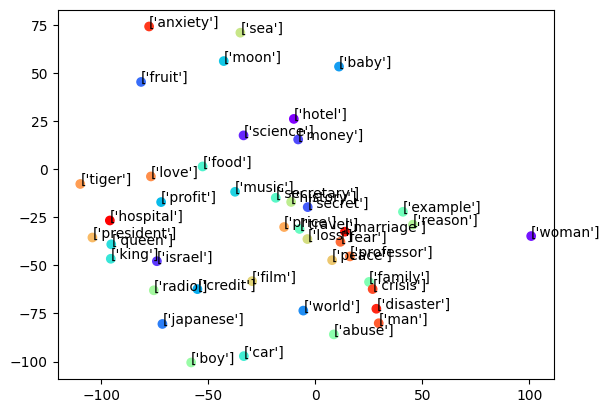

In [48]:
# use matplotlib to display some representative words using their tSNE projections in a 2-D plane
#
import matplotlib.pyplot as plt
import matplotlib.cm as cm

some_words = np.array(['abuse','anxiety','baby','boy','car','credit','disaster','crisis','family','film','food','history',
                      'hospital','hotel','love','loss','money','moon','music','peace','stupid','woman','world','travel','tiger',
                      'secret','sea','secretary','professor','radio','president','profit','price','nurse','man','marriage','example',
                      'fear','fruit','japanese','israel','king','queen','smile','science','reason'])

x = []
y = []
txts = []

indices = np.random.permutation(len(some_words))

for wd in some_words[indices]:
  i = np.where(dict == wd)[0]
  if i:
    x.append(U_2d[i][0][0])
    y.append(U_2d[i][0][1])
    txts.append(dict[i])

colors = cm.rainbow(np.linspace(0, 1, len(txts)))

fig, ax = plt.subplots()
ax.scatter(x, y, c=colors, alpha=1.0)

for i, txt in enumerate(txts):
    ax.annotate(txt, (x[i], y[i]))

In [ ]:
# compare running times of the alternative algorithm (only one epoch) for k=10,20,30

print('k=10')
%timeit -n1 -r1 Alternating_MF(X,k=10,max_epoch=1)

print('k=20')
%timeit -n1 -r1 Alternating_MF(X,k=20,max_epoch=1)

print('k=30')
%timeit -n1 -r1 Alternating_MF(X,k=30,max_epoch=1)

k=10
epoch = 0: loss = 3.5011858711912907
epoch = 1: loss = 1.295887435199746
13min 21s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
k=20
epoch = 0: loss = 3.5011860816718983
epoch = 1: loss = 0.871410215063044
13min 46s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
k=30
epoch = 0: loss = 3.5011859561122822
epoch = 1: loss = 0.5980104570920908
14min 47s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### **Example 8.2:**

Implement the mini-batch stochastic gradient descent (SGD) method using JAX to factorize the given word-document matrix for $k = 10, 20, 30$. Utilize JAX's automatic differentiation method `jax.grad` to compute the gradient for the specified objective function. Compare the performance of the SGD method with the previously discussed alternating algorithm in terms of execution speed.

In [5]:
### Stochastic Gradient Descent for Matrix Factorization
# use jax.grad() to compute the gradient automatically
#
import numpy as np
import scipy.sparse as sparse
import jax.numpy as jnp
from jax import grad, random, device_put

# JAX implementation of vectorized version of loss function Q(U,V) on page 143
# X: a sparse matrix (scipy.sparse.csr_matrix)
# U,V: both dense matrices (X = U @ V.T)
def loss_fun_vec_jax(U, V, X, lambda1=0.1, lambda2=0.1):
  ind = X.nonzero()
  diff = jnp.sum(U[ind[0],:]*V[ind[1],:],axis=1) - jnp.array(X[ind[0],ind[1]]).squeeze()
  loss = jnp.mean(diff*diff)
  loss += lambda1*jnp.sum(U*U)/U.size + lambda2*jnp.sum(V*V)/V.size
  return loss

# X: a sparse matrix (scipy.sparse.csr_matrix)
# k: size for dense vectors
def SGD_MF_autograd(X, k=10, batch_size=100, lambda1=0.1, lambda2=0.1, max_epoch=10, lr=0.01):
  # initialize U and V
  key = random.PRNGKey(1033)
  U = device_put(0.01*random.normal(key, (X.shape[0], k)))
  V = device_put(0.01*random.normal(key, (X.shape[1], k)))
  X_index = X.nonzero()

  loss = loss_fun_vec_jax(U, V, X, lambda1, lambda2)
  print(f'epoch = 0: loss = {loss}')

  for ep in range(max_epoch):
    n = X.count_nonzero()
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, batch_size):
      batch_indices = indices[batch_start:batch_start+batch_size]
      X_data = np.squeeze(np.array(X[X_index[0][batch_indices], X_index[1][batch_indices]]))
      X_batch = sparse.csr_matrix((X_data,(X_index[0][batch_indices],X_index[1][batch_indices])),shape=X.shape)

      [U_grad, V_grad] = grad(loss_fun_vec_jax, argnums=[0,1])(U,V,X_batch)
      U -= lr * U_grad
      V -= lr * V_grad

    loss = loss_fun_vec_jax(U, V, X, lambda1, lambda2)
    print(f'epoch = {ep+1}: loss = {loss}')

  return U,V

In [56]:
U,V = SGD_MF_autograd(X,k=10,batch_size=1000,lr=5.0, max_epoch=5)

epoch = 0: loss = 3.5011855915438623
epoch = 1: loss = 1.5676148517906368
epoch = 2: loss = 0.7317401051322742
epoch = 3: loss = 0.5853945030561969
epoch = 4: loss = 0.4686741365913712
epoch = 5: loss = 0.3980643598173309


In [ ]:
# compare running times of different versions of loss functions
#
print('compute the loss function with numpy:')
%timeit loss_fun_vec(U, V, X)
print('compute the loss function with jax.numpy:')
%timeit loss_fun_vec_jax(U, V, X)

f2 = loss_fun_vec(U, V, X)
f3 = loss_fun_vec_jax(U, V, X)
print(f2,f3)

compute the loss function with numpy:
4.31 s ± 602 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
compute the loss function with jax.numpy:
3.92 s ± 388 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.5011850970297513 3.5011852


### **Example 8.3:**

Rather than employing JAX's automatic differentiation, implement the mini-batch stochastic gradient descent (SGD) method from scratch. Specifically, manually compute the gradient for the given loss function and use it to perform SGD for matrix factorization of the word-document matrix with $k = 10$. Compare the performance of this manually implemented SGD method with the one using JAX's automatic differentiation in Example 8.2 as well as the alternating algorithm in Example 8.1.

Here, we first derive the formula to compute the gradient for the loss function of one mini-batch.

Given any mini-batch $B$ that contain indeices $(i,j)$ of some non-zero  elements in $\mathbf{X}$, the objective function is written as

$$
Q(\mathbf{U}, \mathbf{V}) = \frac{1}{|B|}\sum_{\forall (i,j) \in B} \Big(x_{ij}-\mathbf{u}_i^\intercal \mathbf{v}_j \Big)^2 + \frac{\lambda_1}{|\mathbf{U}|} \sum_{i} || \mathbf{u}_i ||^2
+ \frac{\lambda_2}{|\mathbf{V}|} \sum_{j} || \mathbf{v}_j ||^2
$$
where $|B|$ denotes the mini-batch size, and $|\mathbf{U}|$ and $|\mathbf{V}|$ stand for the number of elements in matrices $\mathbf{U}$ and $\mathbf{V}$.


For all $i$ in $B$,
$$
\frac{\partial Q}{\partial \mathbf{u}_i } = \frac{1}{|B|} \sum_{\forall j, with (i,j) \in B}
2 \big(x_{ij} - \mathbf{u}_i^\intercal \mathbf{v}_j \big) \mathbf{v}_j  + 2 \frac{\lambda_1}{|\mathbf{U}|} \mathbf{u}_i
$$

For all $j$ in $B$,
$$
\frac{\partial Q}{\partial \mathbf{v}_j } = \frac{1}{|B|} \sum_{\forall i, with (i,j) \in B}
2 \big(x_{ij} - \mathbf{u}_i^\intercal \mathbf{v}_j \big) \mathbf{u}_i  + 2 \frac{\lambda_2}{|\mathbf{V}|} \mathbf{v}_j
$$

In [17]:
# use numpy to implement the code to compute the gradient from sractch as above
import numpy as np

def my_grad(U, V, X_batch, lambda1=0.1, lambda2=0.1):
  U_grad = np.zeros_like(U)
  V_grad = np.zeros_like(V)
  ind = X_batch.nonzero()
  n = X_batch.count_nonzero()

  diff = np.sum(U[ind[0],:]*V[ind[1],:],axis=1) - np.array(X[ind[0],ind[1]]).squeeze()
  for i in range(n):
    U_grad[ind[0][i],:] += 2.0*diff[i]*V[ind[1][i],:]/n + 2.0*lambda1*U[ind[0][i],:]/U.size
    V_grad[ind[1][i],:] += 2.0*diff[i]*U[ind[0][i],:]/n + 2.0*lambda2*V[ind[1][i],:]/V.size

  return U_grad,V_grad

In [51]:
# compare execution times of my_grad() vs jax.grad()
k=20
U = 0.01*np.random.normal(size =(X.shape[0], k))
V = 0.01*np.random.normal(size =(X.shape[1], k))
n = X.count_nonzero()
X_index = X.nonzero()

indices = np.random.permutation(n)  #randomly shuffle data indices
batch_indices = indices[0:1000]
X_data = np.squeeze(np.array(X[X_index[0][batch_indices], X_index[1][batch_indices]]))
X_batch = sparse.csr_matrix((X_data,(X_index[0][batch_indices],X_index[1][batch_indices])),shape=X.shape)

[U_grad1, V_grad1] = grad(loss_fun_vec_jax, argnums=[0,1])(U,V,X_batch)

[U_grad2, V_grad2] = my_grad(U, V, X_batch)

diff1 = U_grad1 - U_grad2
diff2 = V_grad1 - V_grad2
print(np.sum(diff1*diff1))
print(np.sum(diff2*diff2))

print("JAX's auto-grad():")
%timeit grad(loss_fun_vec_jax, argnums=[0,1])(U,V,X_batch)
print("my_grad():")
%timeit my_grad(U, V, X_batch)

2.6508717e-11
4.0751823e-13
JAX's auto-grad():
320 ms ± 40 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
my_grad():
29.4 ms ± 849 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The above results show that the manual implementation `my_grad()` runs much faster than the JAX's auto_grad method, about 10x faster in the above example.

In [28]:
### Stochastic Gradient Descent for Matrix Factorization
# use my_grad() to compute the gradient automatically
#
import numpy as np
import scipy.sparse as sparse

# X: a sparse matrix (scipy.sparse.csr_matrix)
# k: size for dense vectors
def SGD_MF_mygrad(X, k=10, batch_size=100, lambda1=0.1, lambda2=0.1, max_epoch=10, lr=0.01):
  # initialize U and V
  U = 0.01*np.random.normal(size =(X.shape[0], k))
  V = 0.01*np.random.normal(size =(X.shape[1], k))
  X_index = X.nonzero()

  loss = loss_fun_vec(U, V, X, lambda1, lambda2)
  print(f'epoch = 0: loss = {loss}')

  for ep in range(max_epoch):
    n = X.count_nonzero()
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, batch_size):
      batch_indices = indices[batch_start:batch_start+batch_size]
      X_data = np.squeeze(np.array(X[X_index[0][batch_indices], X_index[1][batch_indices]]))
      X_batch = sparse.csr_matrix((X_data,(X_index[0][batch_indices],X_index[1][batch_indices])),shape=X.shape)

      [U_grad, V_grad] = my_grad(U,V,X_batch)
      U -= lr * U_grad
      V -= lr * V_grad

    loss = loss_fun_vec(U, V, X, lambda1, lambda2)
    print(f'epoch = {ep+1}: loss = {loss}')

  return U,V

In [34]:
# compare the running times of the alternating algorithm and SGD (with my_grad()) for only one epoch

print('alternating algorithm:')
%timeit -n1 -r1 Alternating_MF(X,k=10,max_epoch=1)

print('SGD with my_grad():')
%timeit -n1 -r1 SGD_MF_mygrad(X,k=10,batch_size=1000,lr=5.0,max_epoch=1)

alternating algorithm:
epoch = 0: loss = 3.501184988321589
epoch = 1: loss = 1.3028441997961089
14min 18s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
SGD with my_grad():
epoch = 0: loss = 3.501185250869073
epoch = 1: loss = 1.5658339774392491
7min 59s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [39]:
# compare the running times of SGD (with my_grad()) with various batch sizes

print('SGD with my_grad() with batch_size = 10000:')
%timeit -n1 -r1 SGD_MF_mygrad(X,k=10,batch_size=10000,lr=50.0,max_epoch=1)

print('SGD with my_grad() with batch_size = 5000:')
%timeit -n1 -r1 SGD_MF_mygrad(X,k=10,batch_size=5000,lr=25.0,max_epoch=1)

print('SGD with my_grad() with batch_size = 500:')
%timeit -n1 -r1 SGD_MF_mygrad(X,k=10,batch_size=500,lr=2.5,max_epoch=1)

SGD with my_grad() with batch_size = 10000:
epoch = 0: loss = 3.5011854518346777
epoch = 1: loss = 1.278080710366883
3min 52s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
SGD with my_grad() with batch_size = 5000:
epoch = 0: loss = 3.5011852338407965
epoch = 1: loss = 1.2643951526287158
4min 31s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
SGD with my_grad() with batch_size = 500:
epoch = 0: loss = 3.501185302334976
epoch = 1: loss = 1.5760852808239176
15min 25s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [41]:
U,V = SGD_MF_mygrad(X,k=10,batch_size=5000,lr=10.0)

epoch = 0: loss = 3.5011853743731107
epoch = 1: loss = 1.964266665818621
epoch = 2: loss = 1.1150749345603548
epoch = 3: loss = 0.8651957810980011
epoch = 4: loss = 0.7486836666340206
epoch = 5: loss = 0.6679032433428455
epoch = 6: loss = 0.5954259470955521
epoch = 7: loss = 0.5510427046919679
epoch = 8: loss = 0.5023076069538065
epoch = 9: loss = 0.459891431550706
epoch = 10: loss = 0.4173822798800479


In [42]:
# train TSNE to project word vectors to 2-D space for visualization
#
from sklearn.manifold import TSNE

print(U.shape,V.shape)

tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3000, random_state=32)
U_2d = np.array(tsne_model_2d.fit_transform(U))

print(U_2d.shape)

(10000, 10) (489860, 10)
(10000, 2)


<ipython-input-44-4cf61c2d0f66>:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if i:


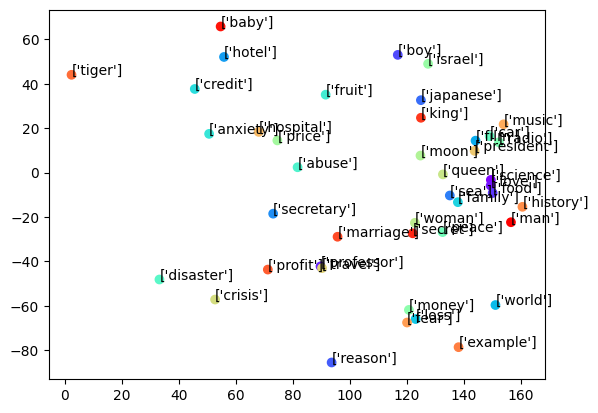

In [44]:
# use matplotlib to display some representative words using their tSNE projections in a 2-D plane
#
import matplotlib.pyplot as plt
import matplotlib.cm as cm

some_words = np.array(['abuse','anxiety','baby','boy','car','credit','disaster','crisis','family','film','food','history',
                      'hospital','hotel','love','loss','money','moon','music','peace','stupid','woman','world','travel','tiger',
                      'secret','sea','secretary','professor','radio','president','profit','price','nurse','man','marriage','example',
                      'fear','fruit','japanese','israel','king','queen','smile','science','reason'])

x = []
y = []
txts = []

indices = np.random.permutation(len(some_words))

for wd in some_words[indices]:
  i = np.where(dict == wd)[0]
  if i:
    x.append(U_2d[i][0][0])
    y.append(U_2d[i][0][1])
    txts.append(dict[i])

colors = cm.rainbow(np.linspace(0, 1, len(txts)))

fig, ax = plt.subplots()
ax.scatter(x, y, c=colors, alpha=1.0)

for i, txt in enumerate(txts):
    ax.annotate(txt, (x[i], y[i]))

## **Exercises**

### **Problem 8.1:**
To assess the quality of word vectors, we can compare the similarities between the derived word vectors to the semantic similarities annotated by humans for the same words. The `WordSim353` dataset provides human-assigned similarity scores for approximately 353 word pairs. For each pair of words in `WordSim353`, calculate the cosine distance between the corresponding derived word vectors. Then, compute the Pearson correlation coefficient between these cosine distances and the human-assigned scores. Discuss the findings from this analysis.

In [ ]:
# download WordSim353 dataset from Google Drive
#
#!gdown https://drive.google.com/file/d/1vzYKmGkKKECwVQgg78imhkNTNLNrXdmU 2> /dev/null

# Or download WordSim353 dataset from YorkU server

!wget -q http://www.cse.yorku.ca/~huijiang/wordsim353_human_scores.txt

### **Problem 8.2:**


Use either the alternating algorithm or gradient descent method to implement collaborative filtering for a movie recommendation task on the [Netflix Prize dataset](https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data/data).